# Visual Odometry pipeline
A naive visual odometry implementation with OpenCV (for now), NumPy & Python

In [1]:
# Fetch data
!bash ../fetch_data.sh

### Run with KITTI
Make sure to download the KITTI odometry dataset and set KITTI=True

### Run with ad-hoc video
Set KITTI variable to False and input variable to the video

In [2]:
import cv2
import open3d as o3d
import time
import numpy as np
import skimage.measure
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
# Handrolled
from utils import display_mat, draw_points
from ransac import ransac
from features import extract_features, bruteforce_match
from geometry import triangulate, fundamental_to_essential, \
    extract_pose, normalize, FundamentalMatrixModel, integrate_pose, calculate_projection, create_normalization_matrix

## Parameters
- KITTI: Defines if the KITTI dataset should be used (requires download from kaggle or the KITTI website)
- input: If KITTI isn't used, this is the file to load for doing VO.
- max_corners: Maximum keypoints returned from goodFeatureToTrack.
- kernel_size: Size of the kernel to search for features with.
- quality: Corner detector "quality".
- ransac_minsamples: The number of samples used by RANSAC
- ransac_max_trial: maximum iteraions of the RANSAC search.
- ransac_residual_threshold: The residual threshold for ransac

In [3]:
# Script parameters
KITTI = False
KITTI_DATA_DIRECTORY = '/Users/haydenpennington/dev/data/kitti/'
input = '../videos/test_countryroad.mp4'
# input = 0
im_size = (640, 480)

# ORB Detector parameters
max_corners = 3000
kernel_size = 3
quality = 0.0001
min_distance = 6

# Ransac parameters
ransac_minsamples = 11
ransac_max_trials = 100
ransac_residual_threshold = 0.001

# Pose extratction translation scaling
tscale = 1.0

# Point cloud clustering
n_points = 3
dbscan_eps = tscale * 0.5

In [4]:
%matplotlib widget

seq = None
mono_folder = None
data_folder = None
train_image_names = None
train_labels = None

if KITTI == True:
    seq = '00'  
    mono_folder = 'image_2'
    data_root = KITTI_DATA_DIRECTORY
    data_folder = data_root + 'sequences/' + seq + '/' + mono_folder + '/'
    train_image_names = sorted([f for f in listdir(data_folder) if isfile(join(data_folder, f))])
    
    with open(data_root + 'poses/' + seq + '.txt', 'r') as f:
        train_labels = [x.split() for x in f.readlines()]
        train_labels = np.array([[float(x) for x in y] for y in train_labels])
        train_labels = train_labels.reshape(-1, 3, 4)


cap = None
if KITTI == False:
    cap = cv2.VideoCapture(input)

In [5]:
def get_image(i, im_size):
    if KITTI == True:
        im = cv2.imread(data_folder + train_image_names[i])
        im_bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_resized = cv2.resize(im_bw, im_size)
        return True, im, im_resized
    else:
        ret, im = cap.read()
        im_bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_resized = cv2.resize(im_bw, im_size)
        return ret, im, im_resized

In [6]:
def match_frames(im_original, T, H, W, kps2, im1, im2):    

    p1, st, err = cv2.calcOpticalFlowPyrLK(im1, im2, kps2, None)
    print("p1")
    print(p1)
    pairs = np.asarray(list(zip(kps2[st == 1], p1[st == 1])))

    # pairs = []
    norm_pairs = []
    print(im1.shape)
    print(pairs.shape)
    
    colors_reduced = skimage.measure.block_reduce(im_original, (30, 30, 1), np.max)
    colors_expanded = cv2.resize(colors_reduced, dsize=(im_original.shape[1], im_original.shape[0]), interpolation=cv2.INTER_CUBIC)
    colors = np.asarray([colors_expanded[int(x), int(y)] for x, y in pairs[:, 0]])  
    plt.imshow(colors[:colors.shape[0] - (colors.shape[0] % 100)].reshape(100, -1))
    plt.show()
    # pair_colors = [im1[int(kp1), int(kp2)] for kp1, kp2 in kps2[st == 1]]
    # print(pair_colors)
    # for m,n in matches:
    #     # Check Lowe's ratio
    #     if m.distance < 0.75 * n.distance:
    #         pt1 = np.asarray(kps1[m.queryIdx].pt)
    #         pt2 = np.asarray(kps2[m.trainIdx].pt)
    #         pairs.append((pt1, pt2))

    # pairs = np.asarray(pairs)
    norm_pairs = np.zeros_like(pairs)
    norm_x = normalize(T, pairs[:, 0])
    norm_y = normalize(T, pairs[:, 1])
    norm_pairs[:, 0] = norm_x
    norm_pairs[:, 1] = norm_y

    # Filter with ransac
    if norm_pairs[:, 0].shape[0] >= ransac_minsamples and norm_pairs[:, 1].shape[0] >= ransac_minsamples:
        F, inliers = ransac(
            FundamentalMatrixModel(),
            norm_pairs,
            min_samples=ransac_minsamples,
            residual_threshold=ransac_residual_threshold,
            max_trials=ransac_max_trials
        )
        return norm_pairs[inliers], pairs[inliers], F, colors

    else:
        return None

colors (2737, 3)
corners (2737, 1, 2)
colors (2736, 3)
corners (2736, 1, 2)
p1
[[[ 74.32017  170.86557 ]]

 [[ 34.892586 211.24704 ]]

 [[ 57.45852  193.79532 ]]

 ...

 [[207.43573  378.58252 ]]

 [[131.08632  404.14197 ]]

 [[153.58566  377.3473  ]]]
(480, 640)
(2657, 2, 2)


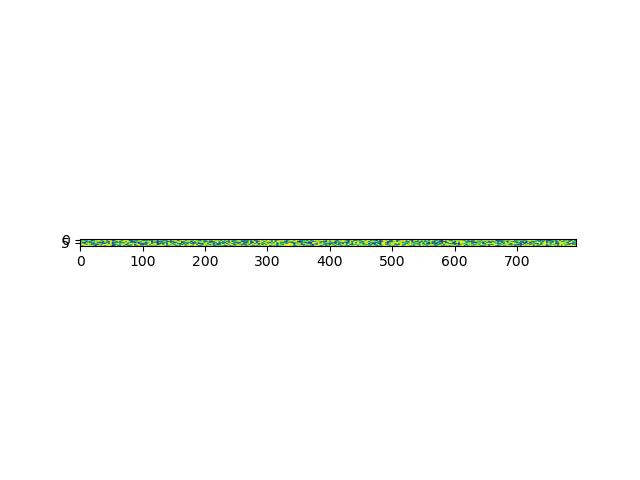

colors (2685, 3)
corners (2685, 1, 2)
p1
[[[ -5.865652 240.27512 ]]

 [[ 45.093983 219.38512 ]]

 [[ 26.622807 196.85031 ]]

 ...

 [[315.5892   395.8376  ]]

 [[407.1819   402.72998 ]]

 [[590.66284  394.44363 ]]]
(480, 640)
(2616, 2, 2)


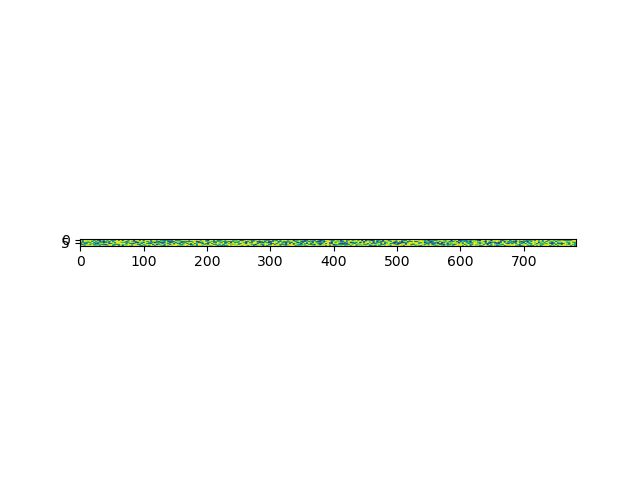

colors (2729, 3)
corners (2729, 1, 2)
p1
[[[ 44.879852 215.73604 ]]

 [[162.30487  180.48648 ]]

 [[123.75104  162.80453 ]]

 ...

 [[ 59.12128  478.23535 ]]

 [[154.99588  407.82425 ]]

 [[542.28455  429.9059  ]]]
(480, 640)
(2662, 2, 2)


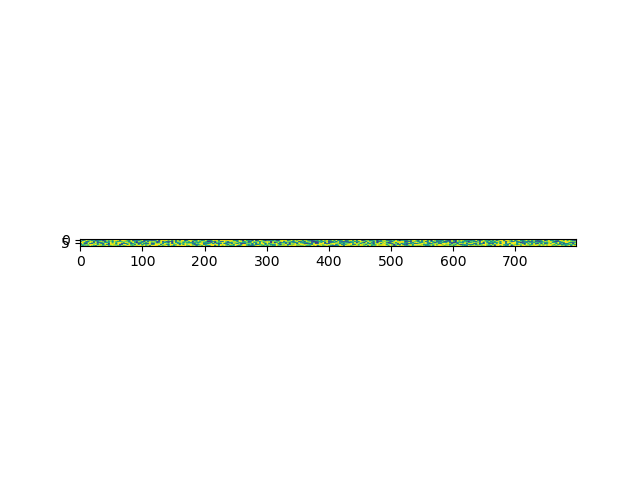

colors (2816, 3)
corners (2816, 1, 2)
p1
[[[ 52.94035  145.21664 ]]

 [[ 31.714666 134.4714  ]]

 [[166.06963  172.62239 ]]

 ...

 [[437.9665   453.10492 ]]

 [[454.7278   391.79376 ]]

 [[399.15958  402.02942 ]]]
(480, 640)
(2722, 2, 2)


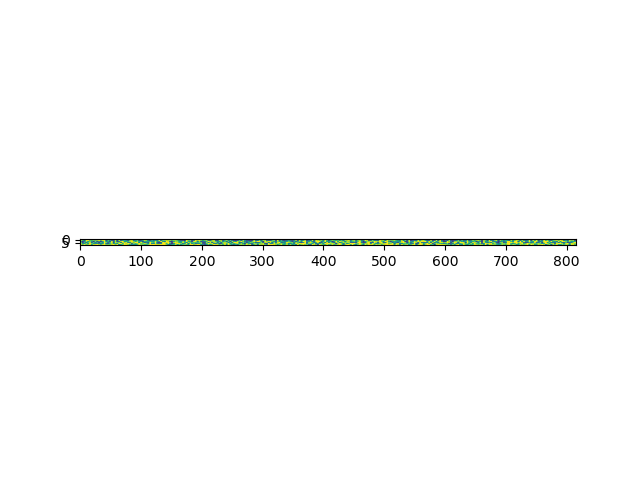

colors (2814, 3)
corners (2814, 1, 2)
p1
[[[159.52296 169.5672 ]]

 [[102.38789 170.89969]]

 [[160.57393 176.48347]]

 ...

 [[196.78804 399.33014]]

 [[545.1903  410.89944]]

 [[405.56354 347.7429 ]]]
(480, 640)
(2689, 2, 2)


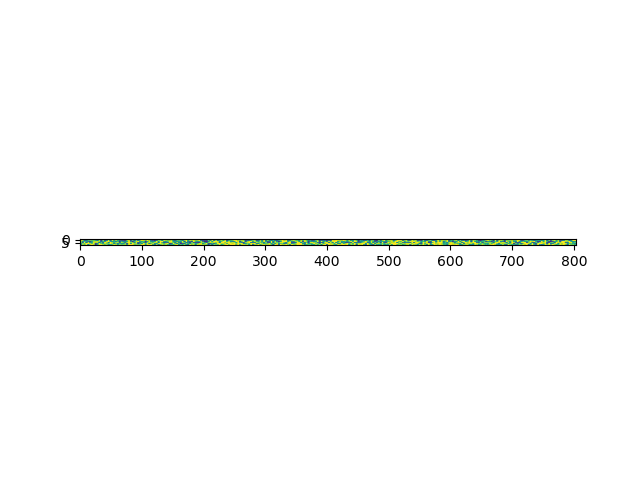

colors (2825, 3)
corners (2825, 1, 2)
p1
[[[153.74615  166.47023 ]]

 [[ 25.833126 100.563644]]

 [[ 26.934837  47.207905]]

 ...

 [[154.53925  417.6664  ]]

 [[479.51486  383.62207 ]]

 [[395.63617  240.20885 ]]]
(480, 640)
(2733, 2, 2)


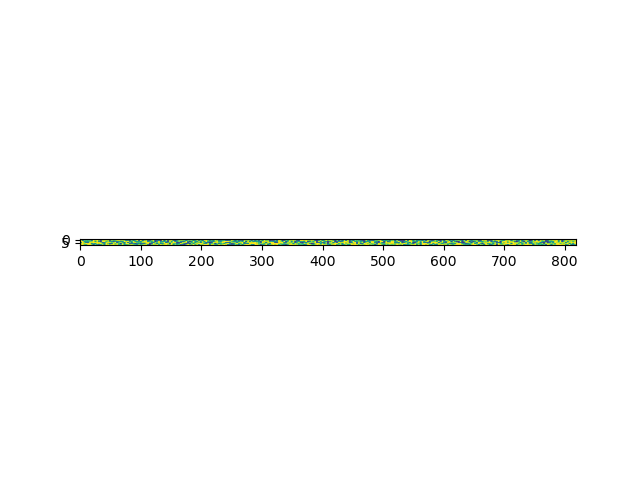

colors (2816, 3)
corners (2816, 1, 2)
p1
[[[140.18805  169.85371 ]]

 [[ 56.674282  79.52113 ]]

 [[147.08339  162.96793 ]]

 ...

 [[622.7145   314.39706 ]]

 [[571.125     32.427204]]

 [[ 24.743738 473.45007 ]]]
(480, 640)
(2732, 2, 2)


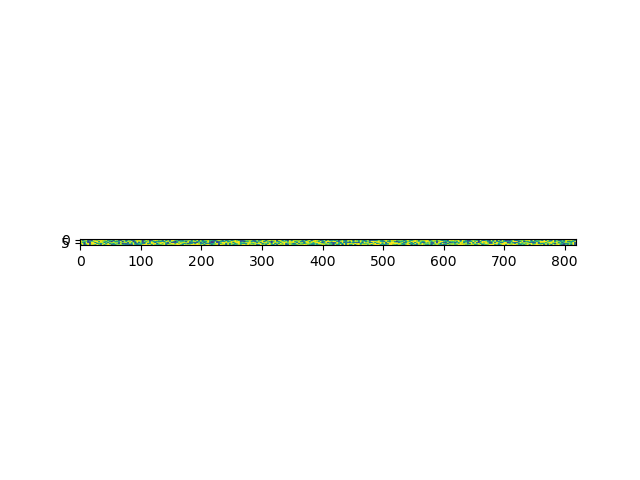

colors (2825, 3)
corners (2825, 1, 2)
p1
[[[135.2255  167.99373]]

 [[186.90253 172.80882]]

 [[141.15123 159.06949]]

 ...

 [[150.80554 375.6708 ]]

 [[362.47043 302.1666 ]]

 [[144.09158 380.70712]]]
(480, 640)
(2740, 2, 2)


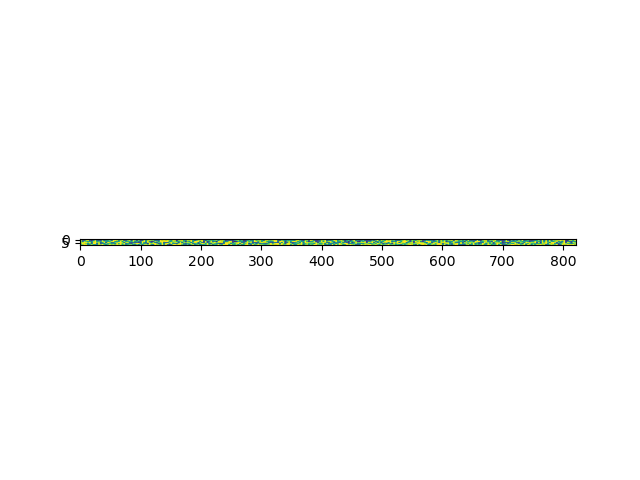

colors (2827, 3)
corners (2827, 1, 2)
p1
[[[185.93755  188.09343 ]]

 [[106.75892  210.172   ]]

 [[131.65875  167.47217 ]]

 ...

 [[292.40344  470.30832 ]]

 [[357.73407  361.71405 ]]

 [[ 45.129845 420.1708  ]]]
(480, 640)
(2734, 2, 2)


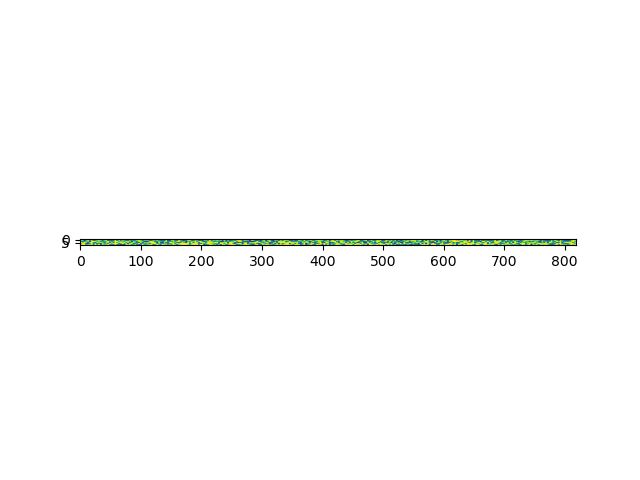

colors (2815, 3)
corners (2815, 1, 2)
p1
[[[125.04595  154.38618 ]]

 [[ 78.506546 180.34181 ]]

 [[ 65.593475  95.98418 ]]

 ...

 [[200.91005  386.8312  ]]

 [[ 57.336864 433.23785 ]]

 [[219.7554   340.02606 ]]]
(480, 640)
(2752, 2, 2)


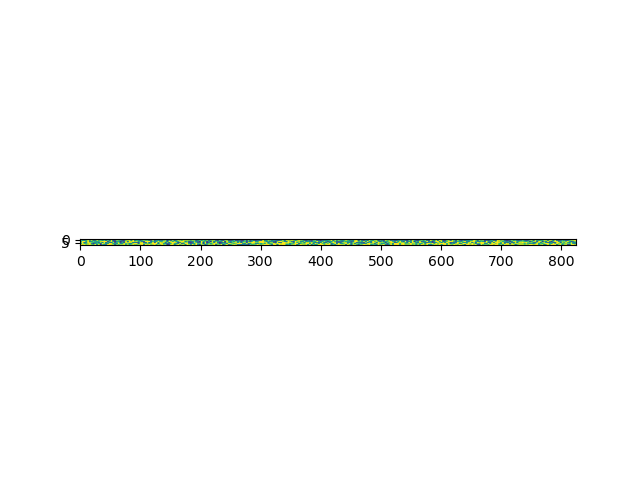

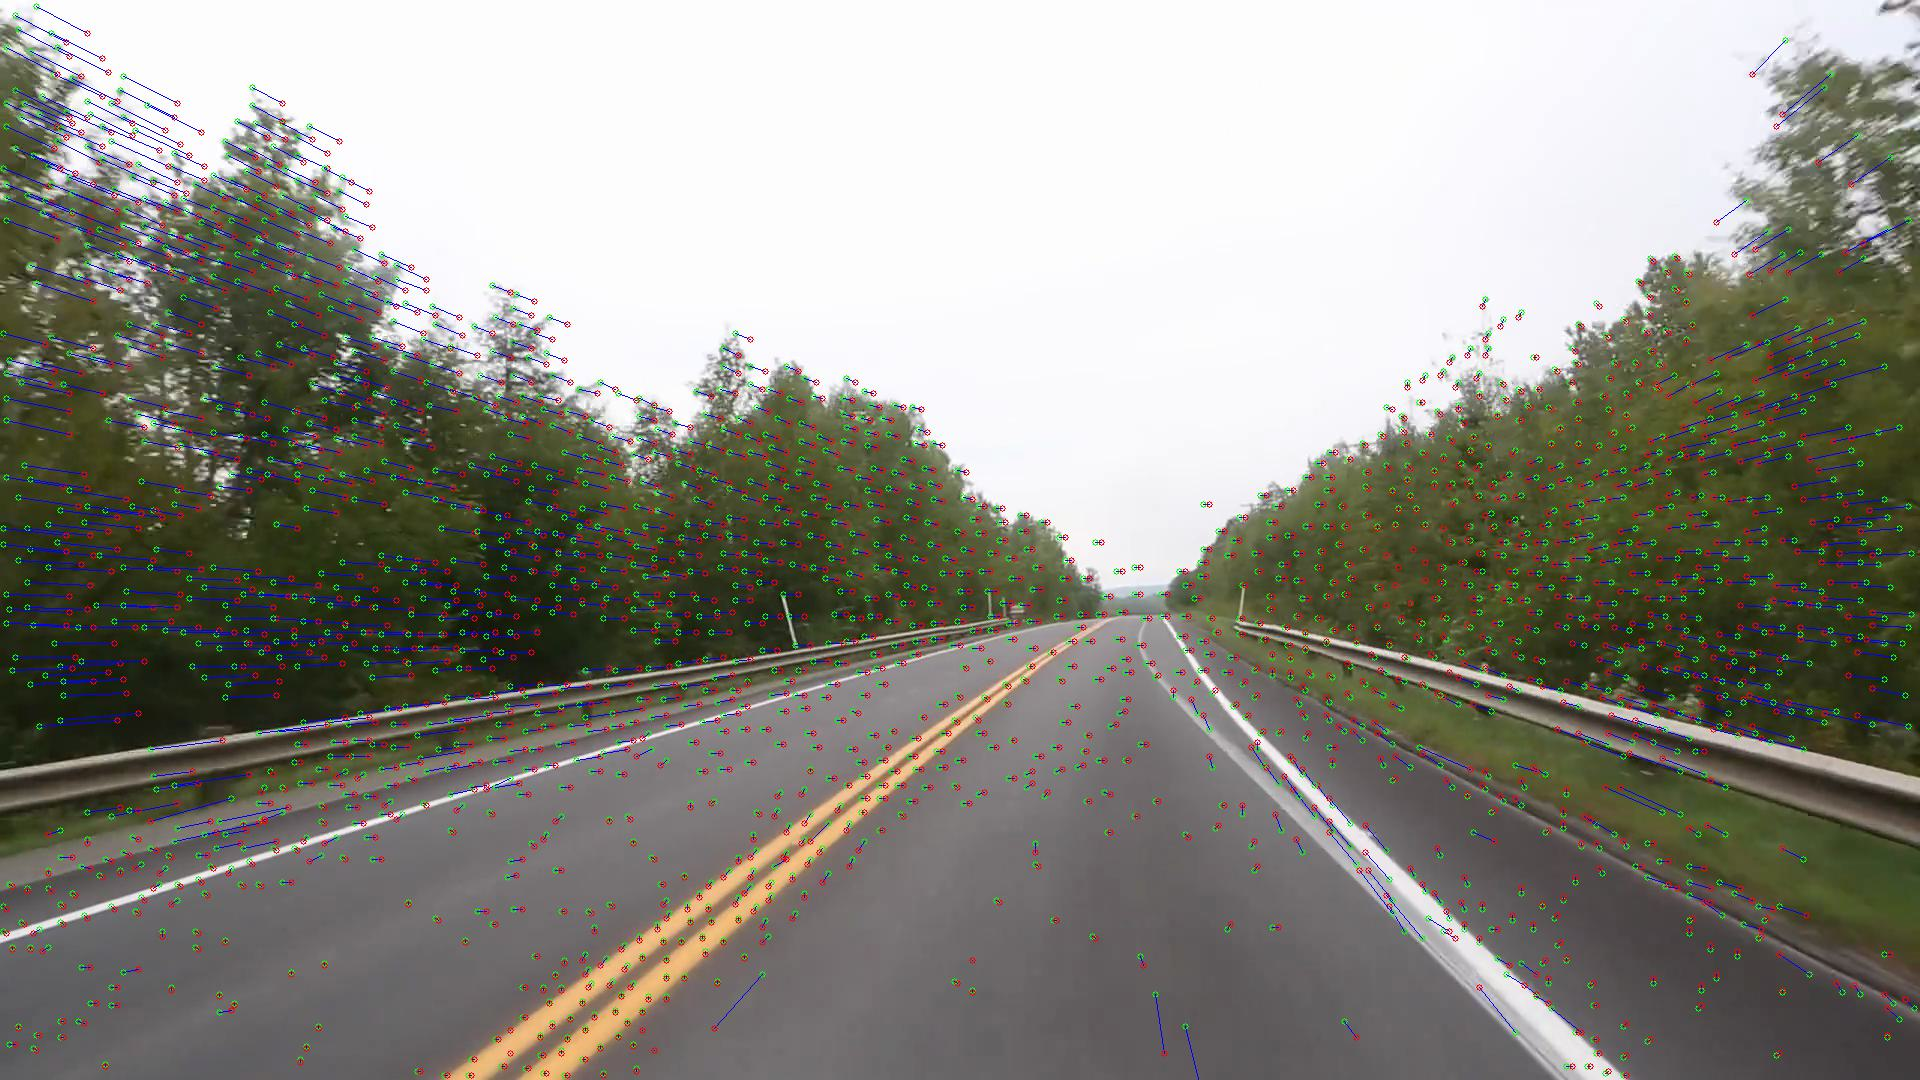

colors (2826, 3)
corners (2826, 1, 2)
p1
[[[ 70.99507  199.57248 ]]

 [[125.00701  174.98085 ]]

 [[116.620094 155.16957 ]]

 ...

 [[555.52295  465.20456 ]]

 [[ 89.568085 427.15533 ]]

 [[ 34.524456 393.06372 ]]]
(480, 640)
(2739, 2, 2)


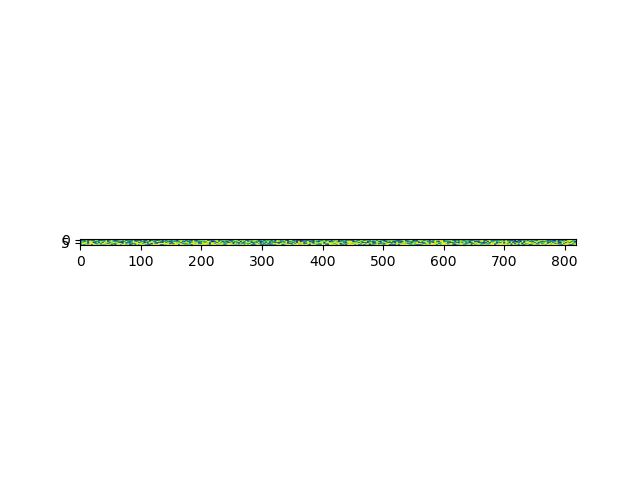

colors (2693, 3)
corners (2693, 1, 2)
p1
[[[ 49.377697 198.80072 ]]

 [[ 75.932335 198.49187 ]]

 [[ 49.810066 173.50984 ]]

 ...

 [[ 60.565437 267.43314 ]]

 [[333.33603  443.7218  ]]

 [[257.5652   476.86557 ]]]
(480, 640)
(2596, 2, 2)


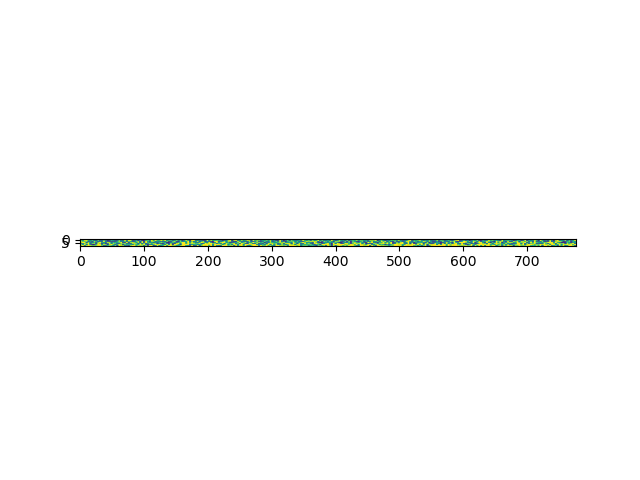

In [7]:
last = None
last_kps = None
last_descriptors = None
last_proj = None
point_cloud = None
point_cloud_colors = None

pose_abs = np.eye(4)
t_abs_all = []
t_abs_gt = []

i = 0

while (KITTI == True and i < len(train_image_names)) or (cap is not None and cap.isOpened()):
    t0 = time.time()
    ret, im_original, im = get_image(i, im_size)
    
    label = None
    
    if KITTI:
        label = train_labels[i]
    
    if ret:
        
        multiplier_x = im_original.shape[1] / im.shape[1]
        multiplier_y = im_original.shape[0] / im.shape[0]
        
        # Create the transformation matrix for normalization
        H, W = im.shape
        T = create_normalization_matrix(H, W)

        if last is not None:
            im1 = im
            im2 = last

            # Extract features with OpenCV
            kps, _ = extract_features(im_original, im1, max_corners, quality, kernel_size, min_distance)
            H, W = im1.shape

            # Use OpenCV's Brute-force matcher to find feature matches between images
            # and compute the filtered pairs of images 
            # as well as the fundamental matrix F
            result = match_frames(im_original, T, H, W, kps, im1, im2)

            if result is not None:

                norm_pairs, feature_pairs, F, colors = result


                if norm_pairs.shape[0] > 1:

                    # Compute the essential matrix from the fundamental matrix
                    E = fundamental_to_essential(F)
                    
                    # Compute the rotation matrix and translation vector between the two frames
                    R, t = extract_pose(E, norm_pairs[0, 0], norm_pairs[0, 1])
                    
                    # Integrate the rotation, and translation matrix/vector with the previos pose 
                    # to compute the current pose.
                    pose_abs = integrate_pose(pose_abs, R, t)
                    
                    # Get the translation of the camera from 4d -> 3d coordinates.
                    t_abs = pose_abs[:3, 3] / pose_abs[3, 3]
                    t_abs_all.append(t_abs)
                    
                    if KITTI == True:
                        t_abs_gt.append(label[:3, 3])
                    
                    Rt = np.eye(4)
                    proj1 = Rt

                    if last_proj is not None:
                        proj1 = calculate_projection(R, t, last_proj)
                        kps1 = norm_pairs[:, 0]
                        kps2 = norm_pairs[:, 1]
                        
                        # Triangulate 4d points
                        points4d, out_colors = triangulate(colors, proj1[:3, :4], last_proj[:3, :4], kps1, kps2, R, t)
                        # 4d homogeneous -> 3d
                        points3d = (points4d / points4d[:, 3:])[:, :3]

                        if point_cloud is None:
                            point_cloud = points3d.reshape(-1, 3)
                            point_cloud_colors = out_colors
                        else:
                            point_cloud = np.concatenate([point_cloud, points3d.reshape(-1, 3)]).reshape(-1, 3)
                            point_cloud_colors = np.concatenate([point_cloud_colors, out_colors])
                    
                    last_proj = proj1
                    
                else:
                    print("norm_pairs.shape[0] < 1")

               

                draw_points(im_original, feature_pairs, multiplier_x, multiplier_y)
        
        last = im

        if last_kps is None:
            last_kps, _ = extract_features(im_original, im, max_corners, quality, kernel_size, min_distance)
        else:
            last_kps = kps

        cv2.imshow('im', im_original)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break

        if (i > 99 and i % 100 == 0) or (i > 0 and i < 11 and i % 10 == 0):
            display_mat(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))

        t1 = time.time()
        t_delta = (t1 - t0)
        # print (1 / t_delta)
        i += 1

    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(4)
if KITTI == False:
    cap.release()

### Save the point cloud for viewing in open3d

In [8]:
# t_abs_all = np.array(t_abs_all).reshape(-1, 3)

# print("point_cloud.shape", point_cloud.shape)
# print("point_cloud_colors.shape", point_cloud_colors.shape)
# assert(point_cloud.shape[0] == point_cloud_colors.shape[0])

if point_cloud is not None:
    pcd = o3d.geometry.PointCloud()
    pcd.transform([
        [-1, 0,  0, 0],
        [ 0, 1,  0, 0],
        [ 0, 0, 1, 0],
        [ 0, 0,  0, 1]
    ])
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    ret = np.array(pcd.cluster_dbscan(eps=dbscan_eps, min_points=n_points))
    all_points = np.concatenate([point_cloud[ret > -1]])
    all_colors = point_cloud_colors[ret > -1].astype(np.float32) / 255.0

    # print(all_colors)
    pcd.points = o3d.utility.Vector3dVector(all_points)
    # all_colors = np.random.rand(len(pcd.points), 3)  # This creates random colors for each point
    # print(all_colors)
    pcd.colors = o3d.utility.Vector3dVector(all_colors)

    # print(pcd.has_colors())
    o3d.io.write_point_cloud("../pointcloud_clustered.pcd", pcd)
    o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display







## Plot the 3d trajectory of the camera
### Red vs Green
Red is the ground truth pose and green is the predicted pose of the camera.

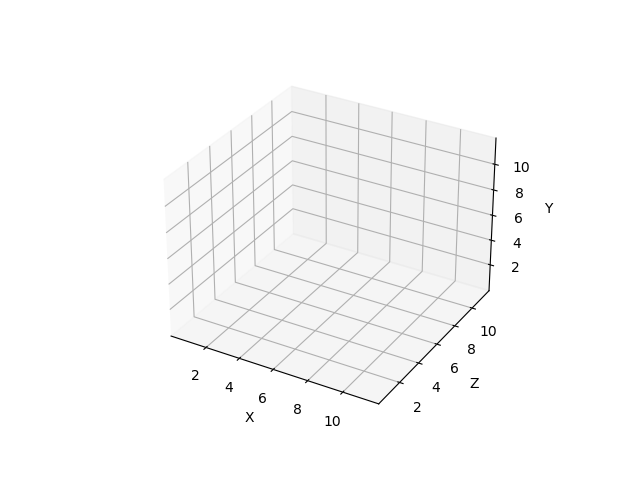

In [9]:
%matplotlib widget
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(t_abs_all[:, 0], t_abs_all[:, 2], t_abs_all[:, 1], color=[(0, 1, 0)])

maximum = None
minimum = None

if KITTI == True:
    t_abs_gt = np.array(t_abs_gt)
    ax.scatter(t_abs_gt[:, 0], t_abs_gt[:, 2], t_abs_gt[:, 1], color=(1, 0, 0))
    minimum = np.array(np.concatenate([t_abs_all, t_abs_gt])).min()
    maximum = np.array(np.concatenate([t_abs_all, t_abs_gt])).max()
else:
    minimum = np.array(t_abs_all).min()
    maximum = np.array(t_abs_all).max()

ax.set_xlim([minimum, maximum])
ax.set_ylim([minimum, maximum])
ax.set_zlim([minimum, maximum])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()
